In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [2]:
sepsis_data = pd.read_csv('dataset/sepsis_dataset.csv')
print("✅ Dataset Loaded Successfully")
print(sepsis_data.head(10))

✅ Dataset Loaded Successfully
   survival  THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6     BLLPLAT  \
0         0        1        19  42.921     15         1   301.80  191.000000   
1         1        1        48  68.818     11         2   118.90  264.156481   
2         0        1        20  68.818     15         2    92.80  123.000000   
3         0        1        19  33.174     14         2  1232.00  244.000000   
4         0        1        48  46.532      3         4  2568.00   45.000000   
5         0        0        21  56.098     14         1   162.65  137.000000   
6         1        0        19  68.818     15         2  2568.00   45.000000   
7         0        1        19  46.532     15         3  4952.00   92.000000   
8         0        1        22  56.098     15         3   118.90  148.601978   
9         1        1        19  56.098     10         3  2568.00  109.000000   

    BLLBILI  BLLCREAT  TIMFIRST      BLADL  blSOFA  
0  2.913416  1.000000     17.17   0.

In [3]:
X = sepsis_data.drop(columns=['survival'])
y = sepsis_data['survival']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X_train, y_train)

# T = realtreatment
Twin_1 = rf.predict_proba(X_test)[:, 1]

# switch treatment
X_test_counterfactual = X_test.copy()
X_test_counterfactual['THERAPY'] = 1 - X_test_counterfactual['THERAPY']

# T = theothertreatment
Twin_2 = rf.predict_proba(X_test_counterfactual)[:, 1]

# ITE
SRF_ITE = np.where(X_test['THERAPY'] == 1, Twin_1 - Twin_2, Twin_2 - Twin_1)

SRF = X_test.copy()
SRF['Outcome'] = y_test
SRF['Twin_1'] = Twin_1
SRF['Twin_2'] = Twin_2
SRF['ITE'] = SRF_ITE

# output_path = os.path.join("Results", "SimpleRandomForest.csv")
# SRF.to_csv(output_path, index=False)

print(SRF.head())

     THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6  BLLPLAT  BLLBILI  \
55         1        48  68.818      3         5  12998.0     78.0      4.8   
73         1        19  38.113      8         1    301.8    359.0      1.9   
33         1        20  46.532     13         4  12998.0     78.0      1.2   
446        0        27  73.138      8         1   1232.0    172.0      0.5   
425        1        23  73.138     15         4    212.3     62.0      1.6   

     BLLCREAT  TIMFIRST      BLADL  blSOFA  Outcome  Twin_1  Twin_2   ITE  
55       20.0     59.17   4.050222    17.0        1    0.46    0.38  0.08  
73        1.0     27.08   0.000000     5.0        0    0.11    0.23 -0.12  
33        3.0     30.67   1.619632    12.0        0    0.05    0.14 -0.09  
446       2.0     67.50  12.000000     7.0        0    0.48    0.51  0.03  
425       3.8     50.67   0.000000    10.0        0    0.13    0.13  0.00  


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_trt1 = X_train[X_train['THERAPY'] == 1]
y_train_trt1 = y_train[X_train['THERAPY'] == 1]
X_train_trt0 = X_train[X_train['THERAPY'] == 0]
y_train_trt0 = y_train[X_train['THERAPY'] == 0]
X_test_trt1 = X_test[X_test['THERAPY'] == 1]
X_test_trt0 = X_test[X_test['THERAPY'] == 0]

model_trt1 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model_trt1.fit(X_train_trt1, y_train_trt1)

model_trt0 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
model_trt0.fit(X_train_trt0, y_train_trt0)

# Compute Twin 1
twin1_scores = np.zeros(len(X_test))

# Fill in the scores based on the original index
twin1_scores[X_test['THERAPY'] == 1] = model_trt1.predict_proba(X_test_trt1)[:, 1]
twin1_scores[X_test['THERAPY'] == 0] = model_trt0.predict_proba(X_test_trt0)[:, 1]

# Compute Twin 2
twin2_scores = np.zeros(len(X_test))

# CROSS OVER: Feed X_1 into rf0, and X_0 into rf1
twin2_scores[X_test['THERAPY'] == 1] = model_trt0.predict_proba(X_test_trt1)[:, 1]
twin2_scores[X_test['THERAPY'] == 0] = model_trt1.predict_proba(X_test_trt0)[:, 1]

DRF_ITE = np.zeros(len(X_test))

# For the Treated group (T=1):
#   P(Y=1|T=1) is Twin 1 (Factual)
#   P(Y=1|T=0) is Twin 2 (Counterfactual)
DRF_ITE[X_test['THERAPY'] == 1] = twin1_scores[X_test['THERAPY'] == 1] - twin2_scores[X_test['THERAPY'] == 1]

# For the Control group (T=0):
#   P(Y=1|T=1) is Twin 2 (Counterfactual)
#   P(Y=1|T=0) is Twin 1 (Factual)
DRF_ITE[X_test['THERAPY'] == 0] = twin2_scores[X_test['THERAPY'] == 0] - twin1_scores[X_test['THERAPY'] == 0]

In [6]:
def compute_kfold_single_rf(X, y, T, treatment_col_name='THERAPY', k=5):
    """
    Computes P1 (prob if treated) and P0 (prob if control) 
    using K-Fold Cross Validation with a SINGLE Random Forest (S-Learner).
    """
    
    # 1. Initialize arrays
    p1_cv = np.zeros(len(X))
    p0_cv = np.zeros(len(X))
    
    # 2. Setup Stratified K-Fold
    # We still stratify by Treatment to ensure good balance in training
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    

    # 3. Loop through folds
    for fold_i, (train_index, val_index) in enumerate(kf.split(X, T)):
        
        # --- A. Prepare Training Data ---
        # Get Features for training fold
        X_train_fold = X.iloc[train_index].copy()
        y_train_fold = y.iloc[train_index]
        T_train_fold = T.iloc[train_index]
        
        # CRITICAL STEP: Add the Treatment column into X as a feature
        # The Single Forest must see 'THERAPY' to learn its effect
        X_train_fold[treatment_col_name] = T_train_fold
        
        # --- B. Train ONE Model ---
        # Train on the WHOLE fold (both Treated and Control mixed)
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train_fold, y_train_fold)
        
        # --- C. Predict on Validation Fold (Counterfactuals) ---
        # Get Features for validation fold
        X_val_fold = X.iloc[val_index]
        
        # 1. Create a dataset where everyone is forced to TREATMENT (T=1)
        X_val_forced_1 = X_val_fold.copy()
        X_val_forced_1[treatment_col_name] = 1
        
        # 2. Create a dataset where everyone is forced to CONTROL (T=0)
        X_val_forced_0 = X_val_fold.copy()
        X_val_forced_0[treatment_col_name] = 0
        
        # 3. Predict Probabilities
        # The model uses the 'THERAPY' column to adjust the prediction
        p1_probs = rf.predict_proba(X_val_forced_1)[:, 1]
        p0_probs = rf.predict_proba(X_val_forced_0)[:, 1]
        
        # Store in arrays
        p1_cv[val_index] = p1_probs
        p0_cv[val_index] = p0_probs

    # 4. Calculate ITE
    ite_cv = p1_cv - p0_cv
    
    return p1_cv, p0_cv, ite_cv

# --- USAGE ---
# Note: Pass the string name of your therapy column so it can be added correctly
P1_vec, P0_vec, KF_ITE = compute_kfold_single_rf(
    X, 
    y, 
    sepsis_data['THERAPY'], 
    treatment_col_name='THERAPY', 
    k=5
)

# Add to dataframe
KF = sepsis_data.copy()
KF['P1_CV'] = P1_vec
KF['P0_CV'] = P0_vec
KF['ITE_CV'] = KF_ITE

In [22]:
import statsmodels.api as sm

# Single Random Forest

# Do NOT convert X_test into a Series (that produces a 2D -> 1D mismatch).
# Keep X_test as the DataFrame produced by train_test_split.
# Create a positionally indexed copy of y_test so iloc uses 0..n-1 positions.
y_test_pos = y_test.reset_index(drop=True)

# Get positional indices (np.where on the underlying array gives positions)
treated_idx = np.where(X_test['THERAPY'].to_numpy() == 1)[0]
control_idx = np.where(X_test['THERAPY'].to_numpy() == 0)[0]

# Build 2D feature arrays with two columns: (Twin_1, Twin_2)
treated_features = np.column_stack((Twin_1[treated_idx], Twin_2[treated_idx]))
control_features = np.column_stack((Twin_1[control_idx], Twin_2[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

# Use the positionally reindexed y_test_pos with iloc
pseudo_ITE_SRF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg = sm.add_constant(SRF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_SRF, linear_reg)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     19.16
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           3.03e-05
Time:                        21:54:52   Log-Likelihood:                -98.275
No. Observations:                  99   AIC:                             200.5
Df Residuals:                      97   BIC:                             205.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1920      0.068      2.814      0.0

In [21]:
#Double Random Forest

# Build 2D feature arrays with two columns: (Twin_1, Twin_2)
treated_features = np.column_stack((twin1_scores[treated_idx], twin2_scores[treated_idx]))
control_features = np.column_stack((twin1_scores[control_idx], twin2_scores[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

# Use the positionally reindexed y_test_pos with iloc
pseudo_ITE_DRF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg = sm.add_constant(DRF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_SRF, linear_reg)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     10.86
Date:                Wed, 03 Dec 2025   Prob (F-statistic):            0.00137
Time:                        21:54:48   Log-Likelihood:                -86.383
No. Observations:                  99   AIC:                             176.8
Df Residuals:                      97   BIC:                             182.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3297      0.059      5.555      0.0

In [20]:
# K Fold

# Build 2D feature arrays with two columns: (Twin_1, Twin_2)
treated_features = np.column_stack((P1_vec[treated_idx], P0_vec[treated_idx]))
control_features = np.column_stack((P1_vec[control_idx], P0_vec[control_idx]))

nn = NearestNeighbors(n_neighbors=1)
nn.fit(control_features)
distances, matched_idx = nn.kneighbors(treated_features)

matched_control_idx = control_idx[matched_idx.flatten()]

# Use the positionally reindexed y_test_pos with iloc
pseudo_ITE_KF = y_test_pos.iloc[treated_idx].to_numpy() - y_test_pos.iloc[matched_control_idx].to_numpy()

linear_reg = sm.add_constant(KF_ITE[treated_idx])
model = sm.OLS(pseudo_ITE_SRF, linear_reg)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5822
Date:                Wed, 03 Dec 2025   Prob (F-statistic):              0.447
Time:                        21:54:39   Log-Likelihood:                -91.339
No. Observations:                  99   AIC:                             186.7
Df Residuals:                      97   BIC:                             191.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2922      0.063      4.607      0.0

Qini

not included in prev methods

Classification Accuracy (Consistency with Pseudo-ITE): 0.7172


C:\Users\jewel\AppData\Local\Temp\ipykernel_23028\1587710949.py:59: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auqc = np.trapz(qini_curve, x_axis) - np.trapz(random_curve, x_axis)


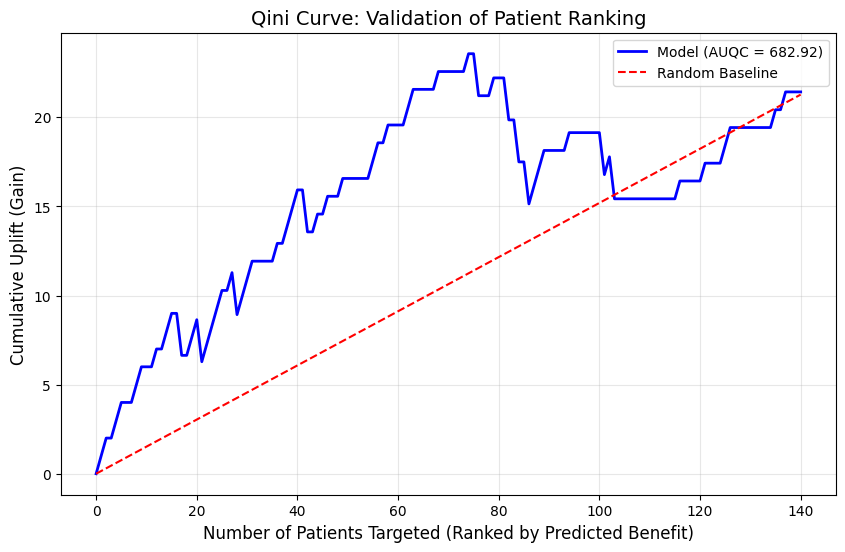

Qini Score (AUQC): 682.92

--- Standardized Mean Difference (SMD) ---
    Variable       SMD
0   PRAPACHE  0.039790
1        AGE  0.066804
2      BLGCS  0.012890
3   ORGANNUM  0.134399
4      BLIL6  0.111211
5    BLLPLAT  0.223479
6    BLLBILI  0.011982
7   BLLCREAT  0.027182
8   TIMFIRST  0.109385
9      BLADL  0.062507
10    blSOFA  0.210072


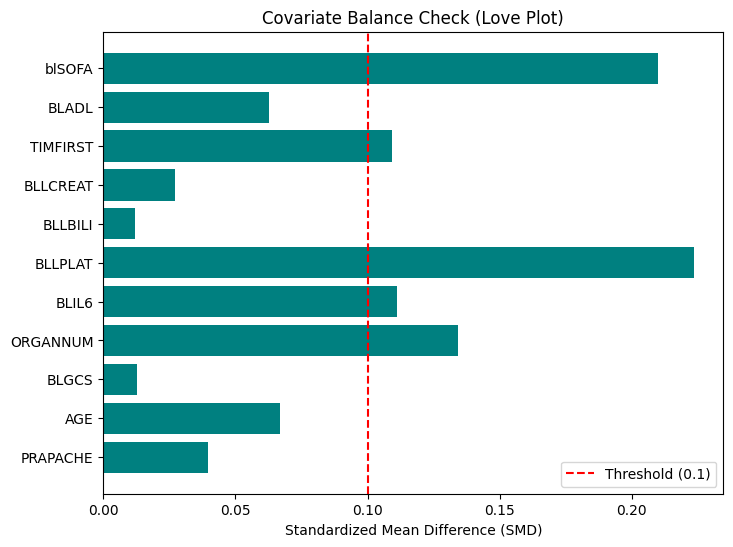

c:\Users\jewel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jewel\AppData\Local\Temp\ipykernel_23028\1587710949.py:155: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_prop[df_prop['Treatment'] == 1]['Propensity_Score'], shade=True, color='blue', label='Treated')
C:\Users\jewel\AppData\Local\Temp\ipykerne

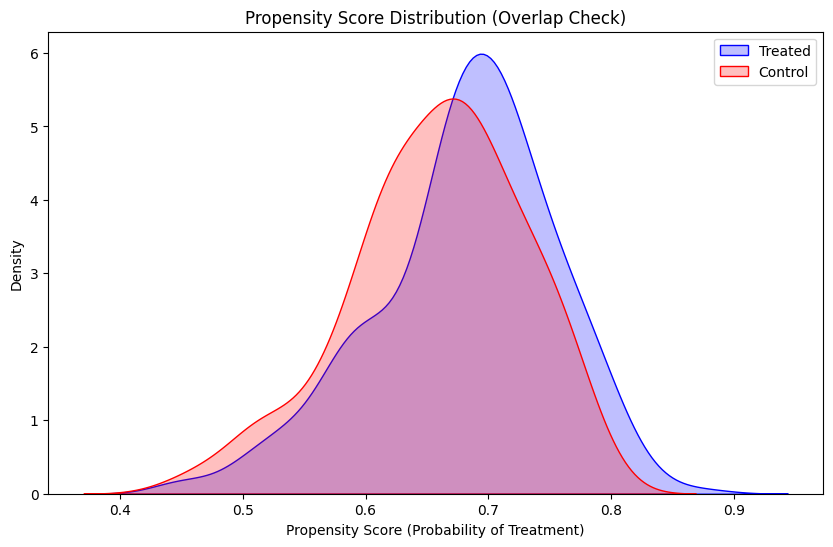

Propensity Score Analysis Complete.


In [24]:
treated_mask = (X_test['THERAPY'] == 1)
model_ite_treated = SRF_ITE[treated_mask]

# Convert to Binary (1 = Benefit, 0 = No Benefit/Harm)
pred_direction = (model_ite_treated > 0).astype(int)
observed_direction = (pseudo_ITE_SRF > 0).astype(int)

accuracy = accuracy_score(observed_direction, pred_direction)
print(f"Classification Accuracy (Consistency with Pseudo-ITE): {accuracy:.4f}")


# ==========================================
# 2. QINI CURVE & SCORE (Ranking)
# ==========================================
def qini_rank(uplift_score, y_true, treatment, plot=True):
    """
    Calculates and plots the Qini Curve (Area Under Uplift Curve).
    """
    # Create a dataframe of results
    results = pd.DataFrame({
        'y': y_true,
        'w': treatment,
        'uplift': uplift_score
    })
    
    # Sort by predicted uplift (High benefit -> Low benefit)
    results = results.sort_values(by='uplift', ascending=False).reset_index(drop=True)
    
    # Calculate cumulative sums
    N_t = results[results['w'] == 1].shape[0]
    N_c = results[results['w'] == 0].shape[0]
    
    # Cumulative responders (y=1)
    cumsum_y_t = np.cumsum(np.where(results['w'] == 1, results['y'], 0))
    cumsum_y_c = np.cumsum(np.where(results['w'] == 0, results['y'], 0))
    
    # Cumulative count of people (N)
    cumsum_n_t = np.cumsum(np.where(results['w'] == 1, 1, 0))
    cumsum_n_c = np.cumsum(np.where(results['w'] == 0, 1, 0))
    
    # Avoid division by zero
    cumsum_n_t[cumsum_n_t == 0] = 1
    cumsum_n_c[cumsum_n_c == 0] = 1
    
    # Calculate Qini Curve
    # Formula: CumSum_Y_T - (CumSum_Y_C * (N_t / N_c))
    factor = N_t / N_c
    qini_curve = cumsum_y_t - (cumsum_y_c * factor)
    
    # --- FIX: Use NumPy Indexing [-1] instead of .iloc[-1] ---
    total_lift = qini_curve[-1] 
    
    x_axis = np.arange(len(results))
    # Random line goes from (0,0) to (Total_Patients, Total_Lift)
    random_curve = x_axis * (total_lift / len(results))
    
    # Calculate Area Under Qini Curve (AUQC)
    # Area between Model and Random
    auqc = np.trapz(qini_curve, x_axis) - np.trapz(random_curve, x_axis)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x_axis, qini_curve, label=f'Model (AUQC = {auqc:.2f})', color='blue', linewidth=2)
        plt.plot(x_axis, random_curve, label='Random Baseline', linestyle='--', color='red')
        plt.xlabel('Number of Patients Targeted (Ranked by Predicted Benefit)', fontsize=12)
        plt.ylabel('Cumulative Uplift (Gain)', fontsize=12)
        plt.title('Qini Curve: Validation of Patient Ranking', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    return auqc

# Run Qini on Test Set
qini_score = qini_rank(SRF_ITE, y_test, X_test['THERAPY'])
print(f"Qini Score (AUQC): {qini_score:.2f}")


# ==========================================
# 3. STANDARDIZED MEAN DIFFERENCE (SMD)
# ==========================================
def calculate_smd(df, treatment_col, covariates):
    """
    Calculates the Standardized Mean Difference (SMD) for covariates
    between Treatment and Control groups.
    SMD < 0.1 indicates good balance.
    """
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    
    smd_data = []
    
    for col in covariates:
        mean_t = treated[col].mean()
        mean_c = control[col].mean()
        var_t = treated[col].var()
        var_c = control[col].var()
        
        # Pooled Standard Deviation
        pooled_sd = np.sqrt((var_t + var_c) / 2)
        
        if pooled_sd == 0:
            smd = 0
        else:
            smd = abs((mean_t - mean_c) / pooled_sd)
            
        smd_data.append({'Variable': col, 'SMD': smd})
        
    return pd.DataFrame(smd_data)

# Calculate SMD on the ORIGINAL dataset (before split, or just Train)
# to prove the RCT assumption holds.
covariate_cols = X.columns.drop(['THERAPY'], errors='ignore') # Exclude Therapy itself
smd_results = calculate_smd(sepsis_data, 'THERAPY', covariate_cols)

print("\n--- Standardized Mean Difference (SMD) ---")
print(smd_results)

# Optional: Plot 'Love Plot' for SMD
plt.figure(figsize=(8, 6))
plt.barh(smd_results['Variable'], smd_results['SMD'], color='teal')
plt.axvline(x=0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.xlabel('Standardized Mean Difference (SMD)')
plt.title('Covariate Balance Check (Love Plot)')
plt.legend()
plt.show()


# ==========================================
# 4. PROPENSITY SCORE (Overlap Check)
# ==========================================
# We estimate P(Treatment | Covariates) using Logistic Regression
# A good RCT should have substantial overlap between Treated and Control distributions.

# Prepare data for Propensity Model (Use simple imputation if needed)
# X_prop should exclude outcome and therapy
X_prop = sepsis_data.drop(columns=['survival', 'THERAPY'])
y_prop = sepsis_data['THERAPY']

# Train Propensity Model
prop_model = LogisticRegression(solver='lbfgs', max_iter=1000)
prop_model.fit(X_prop, y_prop)

# Get Propensity Scores (Probability of Treatment)
propensity_scores = prop_model.predict_proba(X_prop)[:, 1]

# Add to dataframe for plotting
df_prop = pd.DataFrame({
    'Propensity_Score': propensity_scores,
    'Treatment': y_prop
})

# Plot Distribution Overlap
plt.figure(figsize=(10, 6))
sns.kdeplot(df_prop[df_prop['Treatment'] == 1]['Propensity_Score'], shade=True, color='blue', label='Treated')
sns.kdeplot(df_prop[df_prop['Treatment'] == 0]['Propensity_Score'], shade=True, color='red', label='Control')
plt.title('Propensity Score Distribution (Overlap Check)')
plt.xlabel('Propensity Score (Probability of Treatment)')
plt.ylabel('Density')
plt.legend()
plt.show()

print("Propensity Score Analysis Complete.")